# 🧪 EMD Lab: Demixing & Reconstructing Nonstationary Oscillations

**Learning Goals**
1) Generate synthetic coupled oscillatory signals with time-varying amplitude/frequency
2) Decompose signals into IMFs with Empirical Mode Decomposition (EMD)
3) Compute instantaneous phase/frequency/amplitude (Hilbert transform)
4) Build waveform motifs in IF space and map variability via simple PC axes
5) Distort phase alignment and reconstruct a full signal from cycles

✅ At the end, you should be able to interpret Hilbert–Huang spectra and
relate waveform motifs to IF/phase structure.

In [1]:
# Part 0 — Imports & Environment
# ------------------------------
# In this cell we import required libraries and set some globals.
import numpy as np
import matplotlib.pyplot as plt
import emd
import pandas as pd
import seaborn as sns
from scipy.signal import resample

## Part 1 — Demixing Nonstationary Coupled Oscillators
**Goal**: Create a slow (~5 Hz) oscillator whose frequency undulates at 0.5 Hz,
and a fast (~25 Hz) oscillator whose amplitude and frequency depend on the slow phase.

**Tasks**
1. Build timebase: duration T (s), sampling rate fs (Hz)
2. Define slow IF(t) = 5 + 2*sin(2π*0.5*t) and integrate to get slow phase
3. Define fast amplitude and IF as functions of slow phase (ip_slow)
4. Create the composite signal and visualize

**Hint**
- Instantaneous phase from IF: `phi = 2π * cumsum(IF) * dt`
- Wrap phase into [0, 2π] with `np.mod(phi, 2*np.pi)`
- Cosine oscillator: `x = A * cos(phi)`

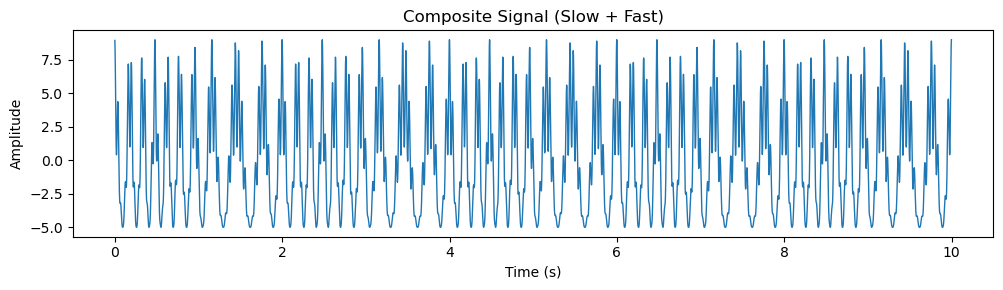

In [2]:
T = 10            # seconds
fs = 1000         # Hz
dt = 1/fs
t = np.arange(0, T, dt)

# Slow oscillator
if_slow = 5 + 2*np.sin(2*np.pi*0.5*t)
ip_slow = 2*np.pi*np.cumsum(if_slow)*dt
ip_slow = np.mod(ip_slow, 2*np.pi)
amp_slow = 5
slow_sig = amp_slow * np.cos(ip_slow)

# Fast oscillator modulated by slow phase
amp_fast = 2 + 2*np.sin(ip_slow + np.pi/2)
if_fast  = 25 + 0.5*np.sin(ip_slow)
ip_fast  = 2*np.pi*np.cumsum(if_fast)*dt
fast_sig = amp_fast * np.cos(ip_fast)

# Composite
sig = slow_sig + fast_sig

# Plot
plt.figure(figsize=(10,3))
plt.plot(t, sig, lw=1)
plt.title("Composite Signal (Slow + Fast)")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

## Part 1.1 — EMD: Decompose into IMFs

IMFs shape: (10000, 3)


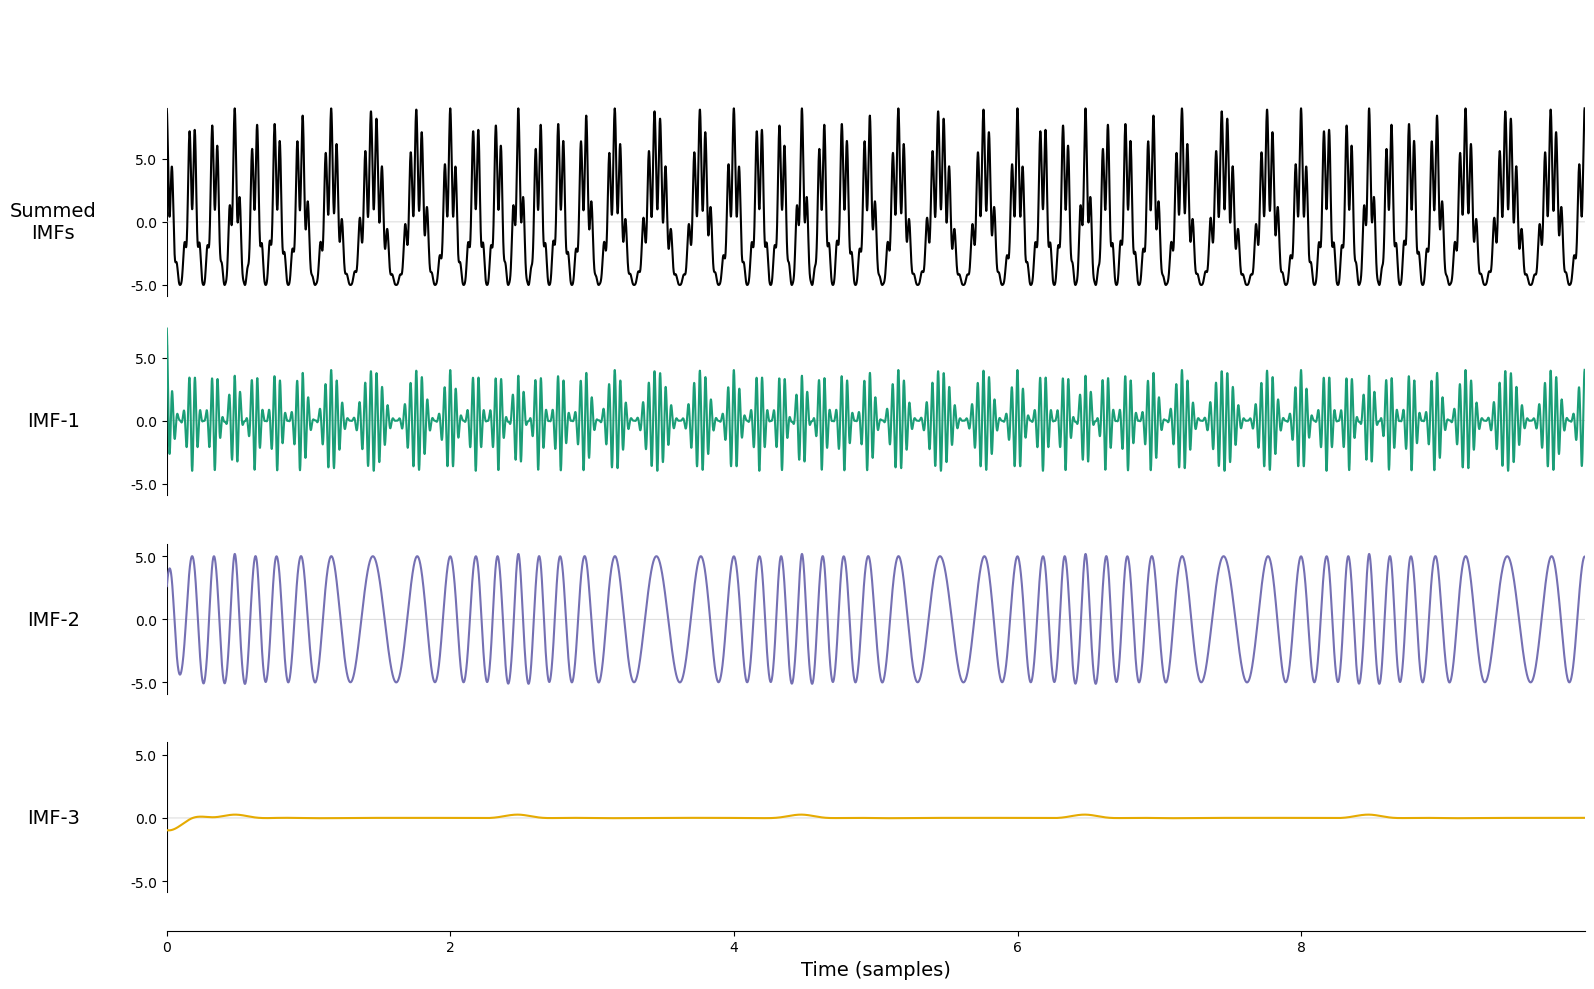

In [3]:
sig_imfs = emd.sift.sift(sig)
print("IMFs shape:", getattr(sig_imfs, 'shape', None))
emd.plotting.plot_imfs(sig_imfs, t)
plt.tight_layout(); plt.show()

## Part 1.2 — Instantaneous Phase / Frequency / Amplitude

IF shape: (10000, 3)


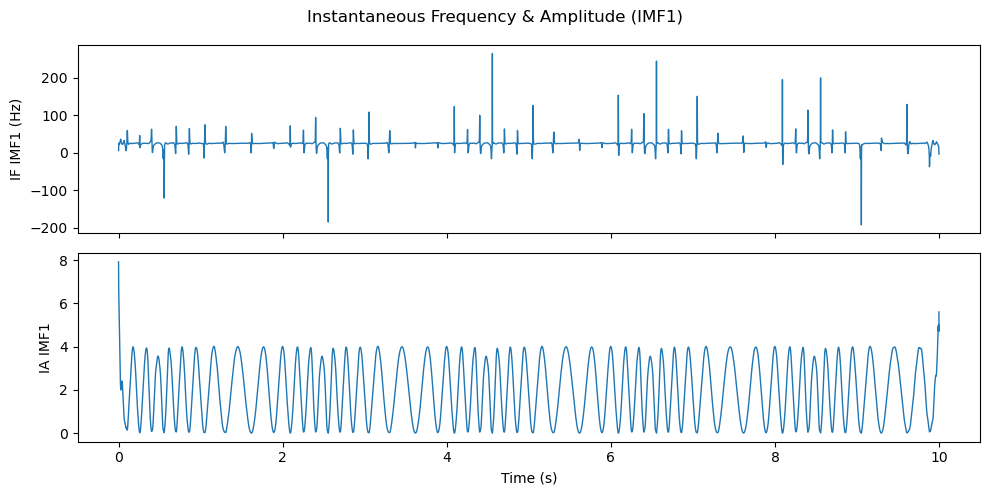

In [4]:
IP, IF, IA = emd.sift.frequency_transform(sig_imfs, fs, 'hilbert')
print("IF shape:", IF.shape)

fig, axes = plt.subplots(2, 1, figsize=(10,5), sharex=True)
axes[0].plot(t, IF[:,0], lw=1); axes[0].set_ylabel("IF IMF1 (Hz)")
axes[1].plot(t, IA[:,0], lw=1); axes[1].set_ylabel("IA IMF1")
axes[1].set_xlabel("Time (s)")
fig.suptitle("Instantaneous Frequency & Amplitude (IMF1)")
plt.tight_layout(); plt.show()

## Part 1.3 — Hilbert–Huang Transform (HHT)

HHT shape: (57, 10000) Freq bins: (57,)


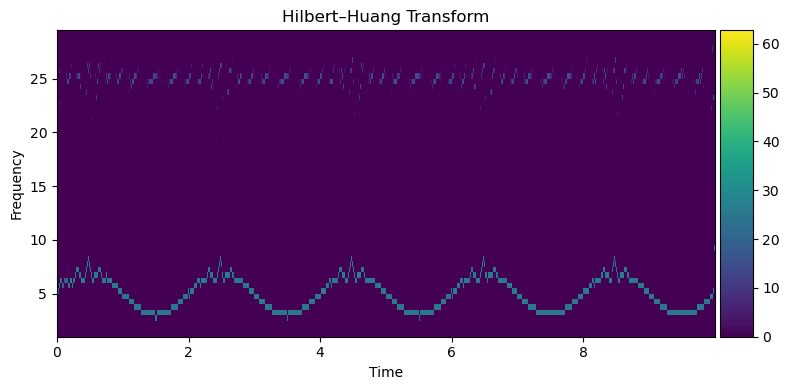

In [5]:
edges = np.arange(1, 30, 0.5)
f, hht = emd.spectra.hilberthuang(IF, IA, edges=edges, sample_rate=fs, sum_time=False)
print("HHT shape:", hht.shape, "Freq bins:", f.shape)
fig, ax = plt.subplots(1,1, figsize=(8,4))
emd.plotting.plot_hilberthuang(hht, t, f, ax=ax, cmap='viridis')
ax.set_title("Hilbert–Huang Transform")
plt.tight_layout(); plt.show()

## Part 1.4 — Cross-Frequency Plot: Fast vs Slow Phase

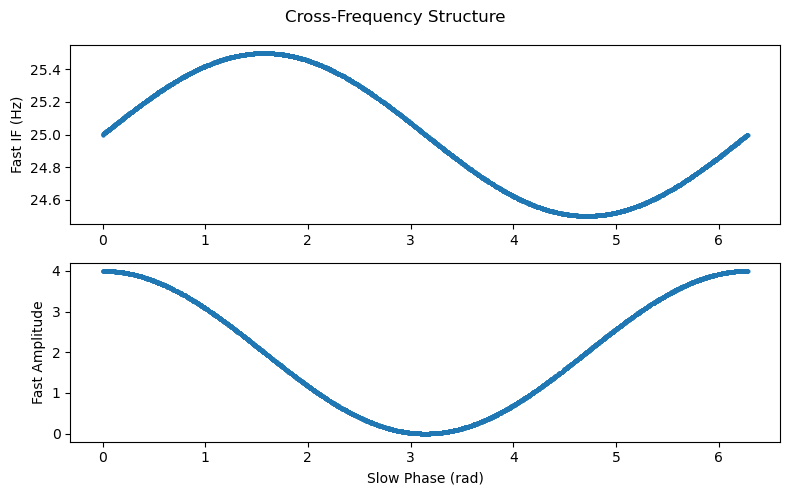

In [6]:
plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
plt.scatter(ip_slow, if_fast, s=4, alpha=0.5)
plt.ylabel("Fast IF (Hz)")
plt.subplot(2,1,2)
plt.scatter(ip_slow, amp_fast, s=4, alpha=0.5)
plt.xlabel("Slow Phase (rad)"); plt.ylabel("Fast Amplitude")
plt.suptitle("Cross-Frequency Structure")
plt.tight_layout(); plt.show()

## Part 2 — Waveform Motifs in IF Space

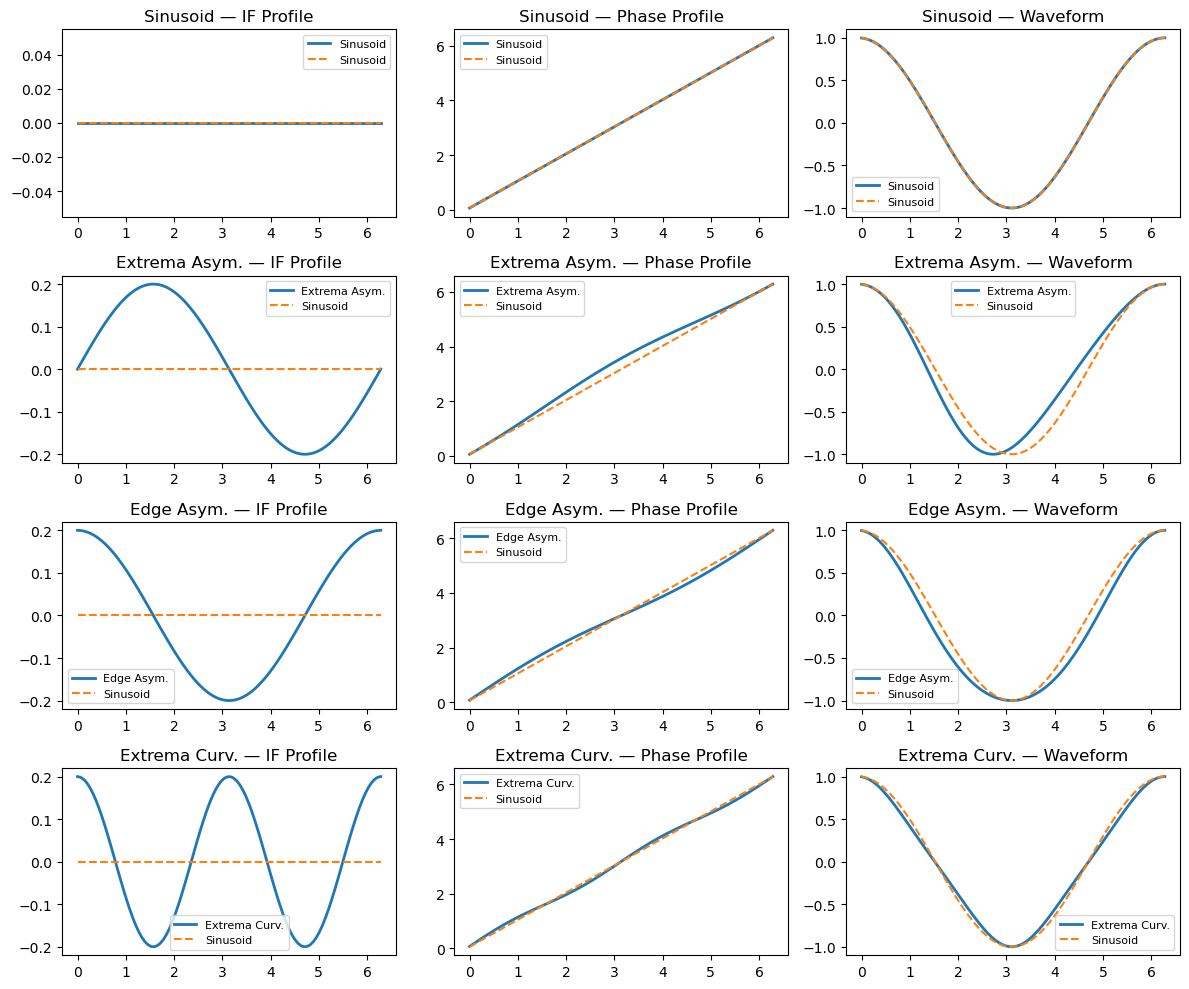

In [7]:
phase_grid = np.linspace(0, 2*np.pi, 100)

def calculate_IF_profile(motif, phase_grid):
    if motif == "sinusoid":
        return np.zeros_like(phase_grid)
    elif motif == "extrema_asymmetry":
        return 0.2 * np.sin(phase_grid)
    elif motif == "edge_asymmetry":
        return 0.2 * np.cos(phase_grid)
    elif motif == "extrema_curvature":
        return 0.2 * np.cos(2 * phase_grid)
    else:
        raise ValueError("Unknown motif")

def calculate_phase_profile(IF_profile):
    cs = np.cumsum(IF_profile)
    denom = np.sum(IF_profile) if np.sum(IF_profile) != 0 else 1.0
    return cs / denom * 2*np.pi

def calculate_waveform(PF_profile):
    return np.cos(PF_profile)

motifs = ["sinusoid", "extrema_asymmetry", "edge_asymmetry", "extrema_curvature"]
IF_profiles = [calculate_IF_profile(m, phase_grid) for m in motifs]
PF_profiles = [calculate_phase_profile(1 + IF) for IF in IF_profiles]
WF_profiles = [calculate_waveform(PF) for PF in PF_profiles]

sinusoid_IF = IF_profiles[0]
sinusoid_PF = PF_profiles[0]
sinusoid_WF = WF_profiles[0]

fig, axes = plt.subplots(4,3, figsize=(12,10))
titles = ["IF Profile", "Phase Profile", "Waveform"]
for i, name in enumerate(["Sinusoid", "Extrema Asym.", "Edge Asym.", "Extrema Curv."]):
    data = [IF_profiles, PF_profiles, WF_profiles]
    for j in range(3):
        axes[i,j].plot(phase_grid, data[j][i], lw=2, label=name)
        axes[i,j].plot(phase_grid, [sinusoid_IF, sinusoid_PF, sinusoid_WF][j], ls="--", label="Sinusoid")
        axes[i,j].set_title(f"{name} — {titles[j]}")
        axes[i,j].legend(fontsize=8)
plt.tight_layout(); plt.show()

## Part 3 — Gaussian Clusters in 3D PC Space

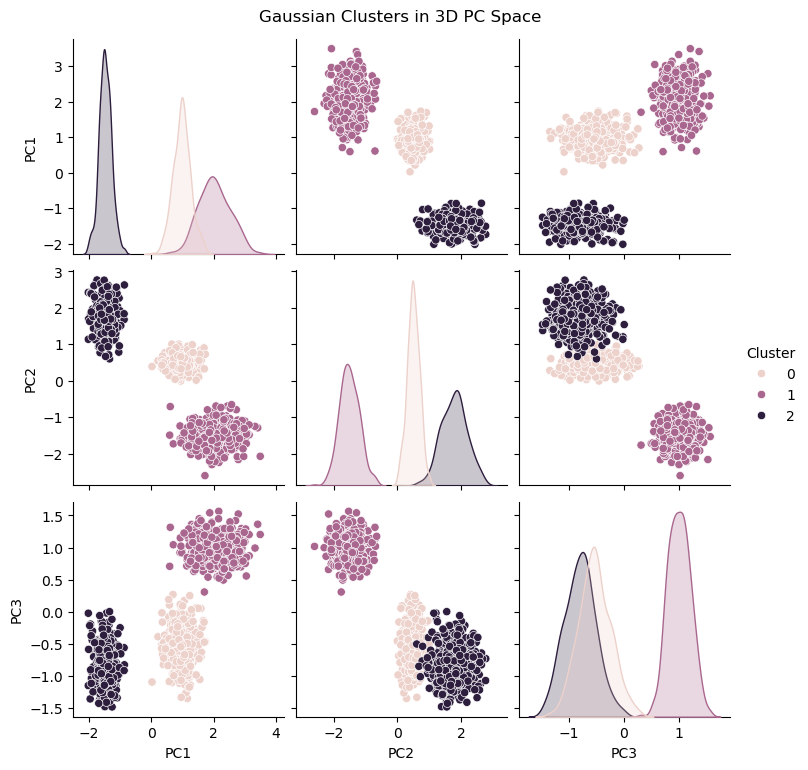

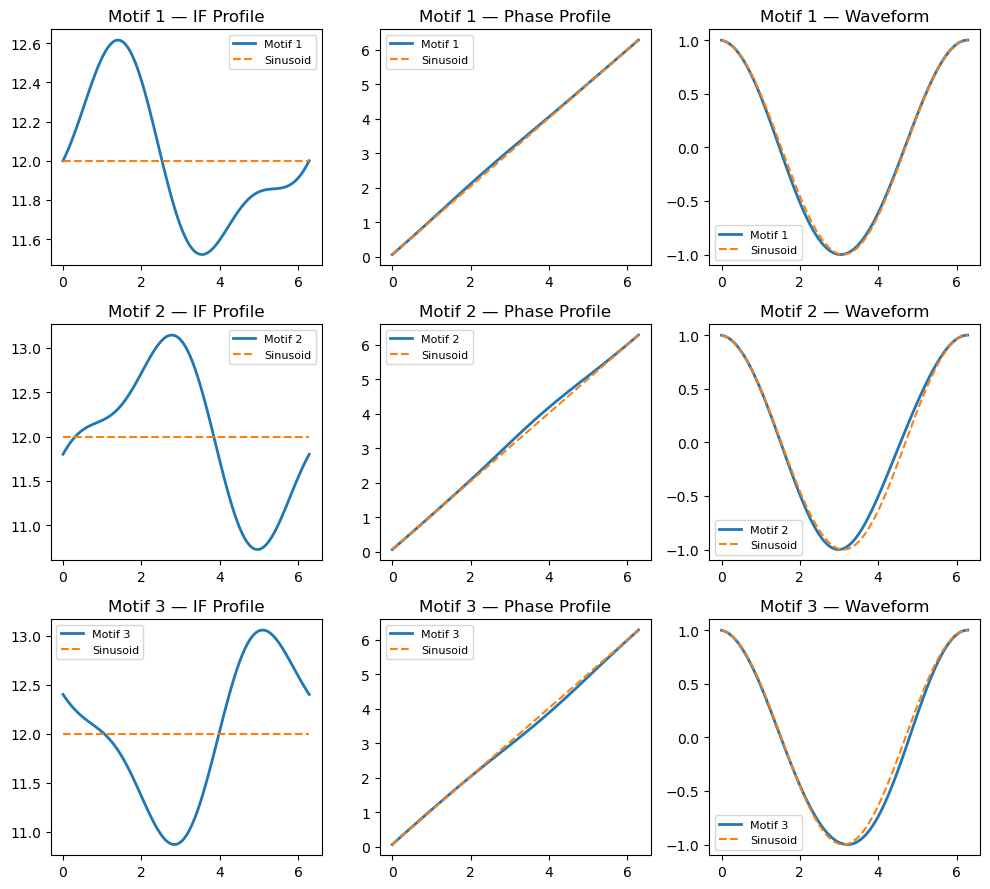

In [8]:
n_pcs = 3
n_clusters = 3
samples_per_cluster = 400
n_cycles = n_clusters * samples_per_cluster

pc_components = np.array(IF_profiles[1:])

cluster_means = np.array([
    [1.0,  0.5, -0.5],
    [2.0, -1.5,  1.0],
    [-1.5, 1.8, -0.8]
])
cluster_stds = np.array([
    [0.3, 0.2, 0.3],
    [0.5, 0.3, 0.2],
    [0.2, 0.4, 0.3]
])

rng = np.random.default_rng(7)
clusters = []
labels = []
for k in range(n_clusters):
    cov = np.diag(cluster_stds[k]**2)
    clusters.append(rng.multivariate_normal(cluster_means[k], cov, size=samples_per_cluster))
    labels.append(np.full(samples_per_cluster, k))
pc_scores = np.vstack(clusters)
cluster_labels = np.concatenate(labels)

df = pd.DataFrame(pc_scores, columns=[f"PC{i+1}" for i in range(n_pcs)])
df["Cluster"] = cluster_labels
sns.pairplot(df, hue="Cluster", diag_kind="kde")
plt.suptitle("Gaussian Clusters in 3D PC Space", y=1.02)
plt.show()

sinusoid_IF_const = 12 * np.ones_like(phase_grid)
cluster_IF_motifs = 2 * cluster_means @ pc_components + 12
cluster_PF_motifs = np.array([calculate_phase_profile(if_prof) for if_prof in cluster_IF_motifs])
cluster_WF_motifs = [calculate_waveform(pf) for pf in cluster_PF_motifs]

fig, axes = plt.subplots(3,3, figsize=(10,9))
plot_titles = ["IF Profile", "Phase Profile", "Waveform"]
for i, motif_name in enumerate(["Motif 1", "Motif 2", "Motif 3"]):
    profiles = [cluster_IF_motifs, cluster_PF_motifs, cluster_WF_motifs]
    baselines = [sinusoid_IF_const, sinusoid_PF, sinusoid_WF]
    for j in range(3):
        axes[i,j].plot(phase_grid, profiles[j][i], lw=2, label=motif_name)
        axes[i,j].plot(phase_grid, baselines[j], ls="--", label="Sinusoid")
        axes[i,j].set_title(f"{motif_name} — {plot_titles[j]}")
        axes[i,j].legend(fontsize=8)
plt.tight_layout(); plt.show()

## Part 4 — Distort Phase Alignment (Variable Samples per Cycle)

IF_design_matrix shape: (1200, 100)


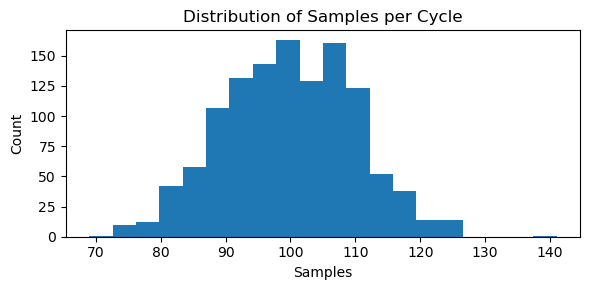

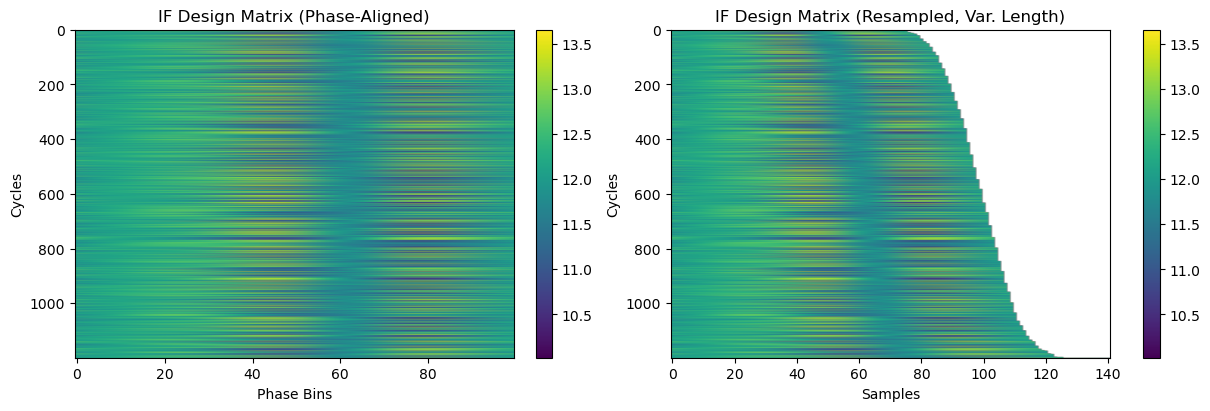

In [9]:
fs_ = 1200
n_phase_bins = phase_grid.size

IF_design_matrix = 2*(pc_scores @ pc_components) + 12
print("IF_design_matrix shape:", IF_design_matrix.shape)

mean = 1.0
std = 0.1
distorted_nsamples = np.round(100 * rng.normal(loc=mean, scale=std, size=(n_cycles,))).astype(int)
distorted_nsamples = np.clip(distorted_nsamples, 50, 150)

plt.figure(figsize=(6,3))
plt.hist(distorted_nsamples, bins=20)
plt.title("Distribution of Samples per Cycle")
plt.xlabel("Samples"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

IF_design_matrix_resampled = np.empty(n_cycles, dtype=object)
for i in range(n_cycles):
    IF_design_matrix_resampled[i] = resample(IF_design_matrix[i], distorted_nsamples[i])

max_len = max(len(x) for x in IF_design_matrix_resampled)
IF_resampled_padded = np.array([
    np.pad(x, (0, max_len - len(x)), mode='constant', constant_values=np.nan)
    for x in IF_design_matrix_resampled
])

order = np.argsort(distorted_nsamples)
A = IF_design_matrix[order]
B = IF_resampled_padded[order]

fig, axes = plt.subplots(1,2, figsize=(12,4), constrained_layout=True)
im1 = axes[0].imshow(A, aspect='auto')
axes[0].set_title("IF Design Matrix (Phase-Aligned)")
axes[0].set_xlabel("Phase Bins"); axes[0].set_ylabel("Cycles")
fig.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(B, aspect='auto')
axes[1].set_title("IF Design Matrix (Resampled, Var. Length)")
axes[1].set_xlabel("Samples"); axes[1].set_ylabel("Cycles")
fig.colorbar(im2, ax=axes[1])
plt.show()

## ✅ Wrap-up & Extensions
- Built a coupled oscillator signal
- Decomposed with EMD into IMFs
- Extracted instantaneous phase/frequency/amplitude
- Built motif-driven IF → phase → waveform mappings
- Distorted cycles and reconstructed a full signal

**Try next:** Apply EMD to `sig_recon` and compare IMFs, or perform PCA on IF matrices.